In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from scipy.stats import hmean
import scipy
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV



In [3]:
"""
just drop the path of your new data directory nothing more than that. 

"""

path = r"C:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\Data\raw"

def read_data(base_path:str) -> pd.DataFrame :
    path = Path(base_path)
    trc=pd.read_excel(path /'TRAIN_NEW'  / 'TRAIN_CATEGORICAL_METADATA_new.xlsx')
    trq=pd.read_excel(path /'TRAIN_NEW'  / 'TRAIN_QUANTITATIVE_METADATA_new.xlsx')
    trf=pd.read_csv(path   /'TRAIN_NEW'  / 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
    trs=pd.read_excel(path /'TRAIN_NEW'  / 'TRAINING_SOLUTIONS.xlsx')  
    tsc=pd.read_excel(path /'TEST'      / 'TEST_CATEGORICAL.xlsx')
    tsq=pd.read_excel(path /'TEST'       / 'TEST_QUANTITATIVE_METADATA.xlsx')    
    tsf=pd.read_csv(path   /'TEST'       / 'TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')    
    sub=pd.read_excel(path / 'SAMPLE_SUBMISSION.xlsx')    
    dic=pd.read_excel(path /'Data Dictionary.xlsx')
    return trc, trq, trf, trs, tsc, tsq, tsf, sub, dic

trc, trq, trf, trs, tsc, tsq, tsf, sub, dic = read_data(base_path=path)

# Data Merging 
cq = pd.merge(trc, trq, on='participant_id', how='left')
feat = pd.merge(cq, trf, on='participant_id', how='left')  
qc = pd.merge(tsc, tsq, on='participant_id', how='left')
train = pd.merge(feat, trs, on='participant_id', how='left') 
test = pd.merge(qc, tsf, on='participant_id', how='left')
train_sex =train

In [4]:
train_ids = train['participant_id']
test_ids = test['participant_id'] # I will store them for later usage in grouping in validation why?  I don't want the same user to appear in both train and test. 
num_feats = trq # numerical features
cat_feats = trc # seperate categorical and numerical features help me reteriving them later easily for preprocessing.
target_cols = ['ADHD_Outcome', 'Sex_F']
groups = train_ids



In [5]:
'''
Train has 25 features/columns with missing values: ['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']
Test  has 23 features/columns with missing values: ['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']
fMRI has no missing values
Extra columns in train: ['MRI_Track_Age_at_Scan', 'MRI_Track_Scan_Location']
'''

# Find columns with missing values only
train_missing_features_to_impute = train.columns[train.isnull().any()].tolist() # List of features with missing values in train, only 25 and no missing data in fMRI data
test_missing_features_to_impute = test.columns[test.isnull().any()].tolist() # List of features with missing values in test, only 23 and no missing data in fMRI data


# Initialize the imputer
imputer = IterativeImputer(estimator=LassoCV(random_state=42), max_iter=5, random_state=42)

# Impute in-place for train
if train_missing_features_to_impute:
	train[train_missing_features_to_impute] = imputer.fit_transform(train[train_missing_features_to_impute])

# Impute in-place for test
if test_missing_features_to_impute:
	test[test_missing_features_to_impute] = imputer.fit_transform(test[test_missing_features_to_impute])

c:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\venv2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.220e+00, tolerance: 4.923e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\venv2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.402e+00, tolerance: 5.646e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Maab\Desktop\ADHD_Kaggle_Competition\Repo\WiDS-Datathon-2025\venv2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You

In [7]:
train.isnull().sum().sum(), test.isnull().sum().sum() # Check if there are any missing values left in train and test data

(0, 0)

In [8]:
train

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.000000,17.903324,32.871543,...,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032,1,0
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.000000,21.000000,45.000000,...,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978,1,0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.000000,12.387745,17.897575,...,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182,0,1
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.000000,18.000000,0.000000,...,-0.199576,-0.216457,0.519074,0.298586,0.415466,0.511607,0.361204,0.446613,0,1
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.000000,13.845904,22.432518,...,-0.141012,-0.002865,0.515169,0.336139,0.316430,0.442230,0.177079,0.378278,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,zwjJWCRzKhDz,2019,4,1.0,1.0,3.0,12.0,15.136452,15.000000,5.000000,...,0.112789,0.211312,0.601190,0.587116,0.312695,0.485938,0.189102,0.354333,0,1
1209,zwXD5v17Rx01,2018,1,0.0,0.0,3.0,21.0,40.000000,21.000000,40.000000,...,0.253990,0.198741,0.648260,0.055241,0.491985,0.118676,0.404331,0.537121,1,0
1210,zWzLCi3NTBTd,2018,3,2.0,3.0,3.0,21.0,40.000000,21.000000,35.000000,...,0.044653,0.234887,0.538475,0.024265,0.472322,0.095624,0.205326,0.182633,1,1
1211,Zy9GTHDxUbXU,2019,4,0.0,1.0,3.0,18.0,35.000000,18.000000,45.000000,...,-0.035955,-0.062152,0.706214,0.183288,0.104987,0.420463,0.152727,0.706737,1,0


In [9]:
# Convert all categorical features to strings (to avoid mixed types)
for feature in trc.columns:
    train[feature] = train[feature].astype(object)
for feature in cat_feats:
    train[feature] = train[feature].astype(str)
    test[feature] = test[feature].astype(str)

# One-Hot Encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

for feature in cat_feats:
    if feature not in train.columns or feature not in test.columns:  # Skip if the feature is missing
        continue

    # Apply OneHotEncoder
    train_encoded = encoder.fit_transform(train[[feature]])
    test_encoded = encoder.transform(test[[feature]])

    # Convert encoded features to DataFrame and append them to the original data
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out([feature]))
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out([feature]))

    # Drop the original feature and concatenate the new encoded columns
    train = pd.concat([train.drop(columns=[feature]), train_encoded_df], axis=1)
    test = pd.concat([test.drop(columns=[feature]), test_encoded_df], axis=1)

In [10]:

scaler = StandardScaler()

# Only apply scaling to numerical columns that are not part of the target or categorical features
numerical_features = [col for col in train.columns if col not in target_cols and col not in cat_feats]

# Fit scaler on the numerical features of the train set and transform train and test sets
train[numerical_features] = scaler.fit_transform(train[numerical_features])  # Fit and transform for train set
test[numerical_features] = scaler.transform(test[numerical_features]) 

In [9]:
train.isnull().sum().sum(), test.isnull().sum().sum() # Check if there are any missing values left in train and test data

(0, 0)

In [12]:
y_sex = train['Sex_F']  
y_adhd = train['ADHD_Outcome']  


# feature importance in sex

In [13]:
X = train.drop(columns=target_cols)
X = pd.get_dummies(X, drop_first=True)

# Initialize the label encoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_sex)
model_sex = lgb.LGBMClassifier()
model_sex.fit(X, y)  # Fit the model before accessing feature_importances_
importances_sex = model_sex.feature_importances_
feature_names = X.columns
feature_importances = zip(feature_names, importances_sex)

[LightGBM] [Info] Number of positive: 416, number of negative: 797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.404363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5075338
[LightGBM] [Info] Number of data points in the train set: 1213, number of used features: 19969
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342951 -> initscore=-0.650169
[LightGBM] [Info] Start training from score -0.650169


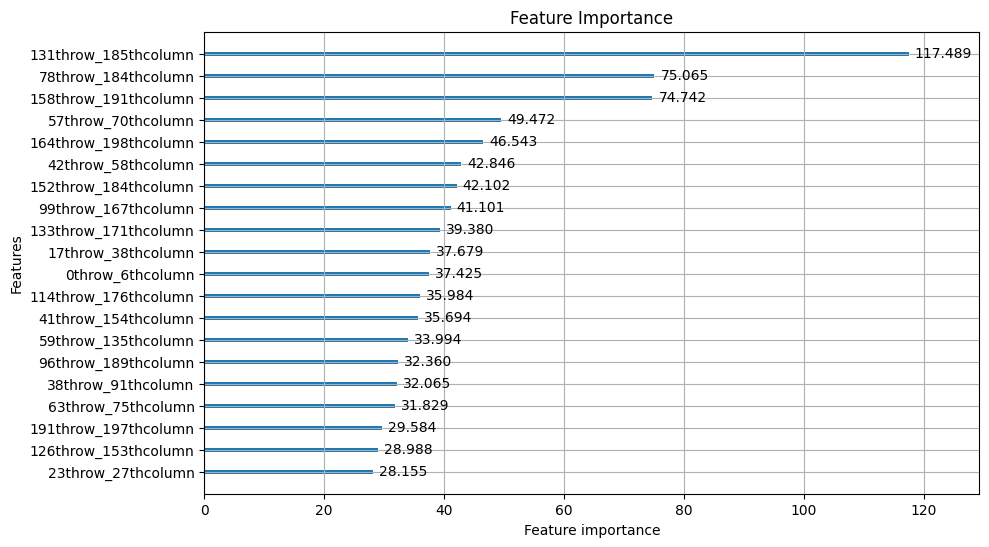

In [12]:
lgb.plot_importance(model_sex, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [29]:
# Get the feature importance values and feature names for the Sex model
feature_importances_sex = model_sex.feature_importances_
feature_names_sex = X.columns


# Create a DataFrame for feature importances
importance_df_sex = pd.DataFrame({'Feature': feature_names_sex, 'Importance': feature_importances_sex})

# Set a threshold for importance (e.g., greater than 0)
important_features_sex = importance_df_sex[importance_df_sex['Importance'] > 0]['Feature']

# Filter the training data to keep only important features for the Sex model
train_sex = train[important_features_sex]
test_sex = test[important_features_sex]


# List of selected features for ADHD
features_adhd = [
    'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
    'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial'
]

# Filter the training and test sets
train_adhd = train[features_adhd].copy()
test_adhd = test[features_adhd].copy()


# Display the new DataFrame
print("Filtered training data for Sex:")
# print(train_sex.head())
print(train_adhd.head())

Filtered training data for Sex:
   ColorVision_CV_Score  APQ_P_APQ_P_CP  APQ_P_APQ_P_ID  APQ_P_APQ_P_INV  \
0             -0.200460       -0.619845        0.466715         0.870819   
1              0.277591       -0.619845       -0.372253        -0.985375   
2              0.277591       -0.619845        2.144650        -0.572888   
3              0.277591       -0.619845       -0.651909         0.458331   
4              0.277591        3.157189       -0.372253        -0.985375   

   APQ_P_APQ_P_OPD  APQ_P_APQ_P_PM  APQ_P_APQ_P_PP  SDQ_SDQ_Conduct_Problems  \
0        -1.195718        0.676164        0.492507                  0.459262   
1         2.118640        2.233637        1.479851                  1.451997   
2         0.009503        1.844269        0.821621                  0.459262   
3        -0.894413        0.676164        0.821621                 -1.029841   
4         1.214724       -0.881308       -0.494837                  1.948365   

   SDQ_SDQ_Difficulties_Total 

# SEX 

## LGBM

In [16]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

# Initialize storage
oof_sex = np.zeros(len(train_sex))
models_sep_sex = {}  # Initialize models_sep_sex as an empty dictionary
bag_f1_sex = []

BAGS = 5
FOLDS = 5

# Prepare data
train_sex_filtered = train_sex.reset_index(drop=True)
y_sex = y_sex.reset_index(drop=True)

for bag in range(BAGS):
    print('#'*25)
    print(f'### Bag {bag+1}')
    print('#'*25)
    
    models_sep_sex[bag] = []
    bag_pred_sex = np.zeros(len(train_sex))
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    fold_f1_sex = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train_sex_filtered, y=y_sex)):
        print(f'=> Fold {fold+1}, ', end='')

        # Dynamic class balancing
        y_train_sex = y_sex.iloc[train_idx]
        class_counts = y_train_sex.value_counts()
        majority_class = class_counts.idxmax()
        minority_class = 1 - majority_class
        
        majority_samples = y_train_sex[y_train_sex == majority_class]
        minority_samples = y_train_sex[y_train_sex == minority_class]
        
        n_samples = len(minority_samples)
        if len(majority_samples) < n_samples:
            n_samples = len(majority_samples)
        
        downsampled_majority = majority_samples.sample(
            n=n_samples, 
            replace=len(majority_samples) < len(minority_samples),
            random_state=bag*BAGS+fold
        )
        
        sex_train_idx = minority_samples.index.union(downsampled_majority.index)
        X_train_sex = train_sex_filtered.iloc[sex_train_idx]
        y_train_sex_balanced = y_sex.iloc[sex_train_idx]
        X_valid_sex = train_sex_filtered.iloc[valid_idx]
        y_valid_sex = y_sex.iloc[valid_idx]

        # Model parameters
        model_params = {
            'n_estimators': 300,
            'learning_rate': 0.175, 
            'metric': 'cross_entropy_lambda',
            'objective': None,
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'reg_alpha': 0.0,
            'reg_lambda': 0.0009,
            'early_stopping_round': 50,
            'feature_fraction': 0.1,
            'subsample': 0.8,
            'class_weight': 'balanced',
            'verbose': -1
        }

        model_sep_sex = LGBMClassifier(**model_params)
        model_sep_sex.fit(X_train_sex, y_train_sex_balanced,
                          eval_set=[(X_valid_sex, y_valid_sex)])

        sex_pred = model_sep_sex.predict(X_valid_sex)
        fold_f1_sex.append(f1_score(y_valid_sex, sex_pred, average='macro'))
        
        bag_pred_sex[valid_idx] = model_sep_sex.predict_proba(X_valid_sex)[:, 1]
        models_sep_sex[bag].append(model_sep_sex)

    bag_avg_f1_sex = np.mean(fold_f1_sex)
    bag_f1_sex.append(bag_avg_f1_sex)
    print(f"\nBag {bag+1} Avg F1 - Sex: {bag_avg_f1_sex:.4f}")
    oof_sex += bag_pred_sex / BAGS

# Final evaluation
final_f1_sex = f1_score(y_sex, (oof_sex > 0.5).astype(int), average='macro')
print('\n' + '#'*50)
print(f"Final Ensemble F1 - Sex: {final_f1_sex:.4f}")
print(f"Mean Bag F1 - Sex: {np.mean(bag_f1_sex):.4f} ± {np.std(bag_f1_sex):.4f}")


#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 1 Avg F1 - Sex: 0.7169
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 2 Avg F1 - Sex: 0.6952
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 3 Avg F1 - Sex: 0.7111
#########################
### Bag 4
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 4 Avg F1 - Sex: 0.7126
#########################
### Bag 5
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 5 Avg F1 - Sex: 0.7042

##################################################
Final Ensemble F1 - Sex: 0.7532
Mean Bag F1 - Sex: 0.7080 ± 0.0076


## Logistic

### Sex

In [31]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Initialize storage
oof_sex = np.zeros(len(train_sex))
models_sep_sex = {}
bag_f1_sex = []

BAGS = 5
FOLDS = 5

# Prepare data
train_sex_filtered = train_sex.reset_index(drop=True)
y_sex = y_sex.reset_index(drop=True)

for bag in range(BAGS):
    print('#' * 25)
    print(f'### Bag {bag+1}')
    print('#' * 25)

    models_sep_sex[bag] = []
    bag_pred_sex = np.zeros(len(train_sex))
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    fold_f1_sex = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train_sex_filtered, y=y_sex)):
        print(f'=> Fold {fold+1}, ', end='')

        # Use full training data without downsampling
        X_train_sex = train_sex_filtered.iloc[train_idx]
        y_train_sex = y_sex.iloc[train_idx]
        X_valid_sex = train_sex_filtered.iloc[valid_idx]
        y_valid_sex = y_sex.iloc[valid_idx]

        # Logistic Regression model
        model_sep_sex = LogisticRegression(
            penalty='l2',
            C=0.02,
            solver='lbfgs',
            class_weight='balanced',
            max_iter=1000,
            random_state=bag * BAGS + fold
        )

        model_sep_sex.fit(X_train_sex, y_train_sex)

        sex_pred = model_sep_sex.predict(X_valid_sex)
        fold_f1_sex.append(f1_score(y_valid_sex, sex_pred, average='macro'))

        bag_pred_sex[valid_idx] = model_sep_sex.predict_proba(X_valid_sex)[:, 1]
        models_sep_sex[bag].append(model_sep_sex)

    bag_avg_f1_sex = np.mean(fold_f1_sex)
    bag_f1_sex.append(bag_avg_f1_sex)
    print(f"\nBag {bag+1} Avg F1 - Sex: {bag_avg_f1_sex:.4f}")
    oof_sex += bag_pred_sex / BAGS

# Final evaluation
final_f1_sex = f1_score(y_sex, (oof_sex > 0.5).astype(int), average='macro')
print('\n' + '#' * 50)
print(f"Final Ensemble F1 - Sex: {final_f1_sex:.4f}")
print(f"Mean Bag F1 - Sex: {np.mean(bag_f1_sex):.4f} ± {np.std(bag_f1_sex):.4f}")


#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 1 Avg F1 - Sex: 0.7920
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 2 Avg F1 - Sex: 0.7788
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 3 Avg F1 - Sex: 0.7819
#########################
### Bag 4
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 4 Avg F1 - Sex: 0.8032
#########################
### Bag 5
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 5 Avg F1 - Sex: 0.7946

##################################################
Final Ensemble F1 - Sex: 0.8082
Mean Bag F1 - Sex: 0.7901 ± 0.0088


### ADHD

In [30]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Initialize storage
oof_adhd = np.zeros(len(train_adhd))
models_sep_adhd = {}
bag_f1_adhd = []

BAGS = 5
FOLDS = 5

# Prepare data
train_adhd_filtered = train_adhd.reset_index(drop=True)
y_adhd = y_adhd.reset_index(drop=True)

for bag in range(BAGS):
    print('#'*25)
    print(f'### Bag {bag+1}')
    print('#'*25)

    models_sep_adhd[bag] = []
    bag_pred_adhd = np.zeros(len(train_adhd))
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    fold_f1_adhd = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train_adhd_filtered, y=y_adhd)):
        print(f'=> Fold {fold+1}, ', end='')

        # Dynamic class balancing
        y_train_adhd = y_adhd.iloc[train_idx]
        class_counts = y_train_adhd.value_counts()
        majority_class = class_counts.idxmax()
        minority_class = 1 - majority_class

        majority_samples = y_train_adhd[y_train_adhd == majority_class]
        minority_samples = y_train_adhd[y_train_adhd == minority_class]

        n_samples = len(minority_samples)
        if len(majority_samples) < n_samples:
            n_samples = len(majority_samples)

        downsampled_majority = majority_samples.sample(
            n=n_samples,
            replace=len(majority_samples) < len(minority_samples),
            random_state=bag*BAGS+fold
        )

        adhd_train_idx = minority_samples.index.union(downsampled_majority.index)
        X_train_adhd = train_adhd_filtered.iloc[adhd_train_idx]
        y_train_adhd_balanced = y_adhd.iloc[adhd_train_idx]
        X_valid_adhd = train_adhd_filtered.iloc[valid_idx]
        y_valid_adhd = y_adhd.iloc[valid_idx]

        # Logistic Regression model
        model_sep_adhd = LogisticRegression(
            penalty='l2',
            C=0.02,
            solver='lbfgs',
            class_weight='balanced',
            max_iter=1000,
            random_state=bag*BAGS+fold
        )

        model_sep_adhd.fit(X_train_adhd, y_train_adhd_balanced)

        adhd_pred = model_sep_adhd.predict(X_valid_adhd)
        fold_f1_adhd.append(f1_score(y_valid_adhd, adhd_pred, average='macro'))

        bag_pred_adhd[valid_idx] = model_sep_adhd.predict_proba(X_valid_adhd)[:, 1]
        models_sep_adhd[bag].append(model_sep_adhd)

    bag_avg_f1_adhd = np.mean(fold_f1_adhd)
    bag_f1_adhd.append(bag_avg_f1_adhd)
    print(f"\nBag {bag+1} Avg F1 - ADHD: {bag_avg_f1_adhd:.4f}")
    oof_adhd += bag_pred_adhd / BAGS

# Final evaluation
final_f1_adhd = f1_score(y_adhd, (oof_adhd > 0.5).astype(int), average='macro')
print('\n' + '#'*50)
print(f"Final Ensemble F1 - ADHD: {final_f1_adhd:.4f}")
print(f"Mean Bag F1 - ADHD: {np.mean(bag_f1_adhd):.4f} ± {np.std(bag_f1_adhd):.4f}")


#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 1 Avg F1 - ADHD: 0.7395
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 2 Avg F1 - ADHD: 0.7291
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 3 Avg F1 - ADHD: 0.7302
#########################
### Bag 4
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 4 Avg F1 - ADHD: 0.7326
#########################
### Bag 5
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 5 Avg F1 - ADHD: 0.7361

##################################################
Final Ensemble F1 - ADHD: 0.7338
Mean Bag F1 - ADHD: 0.7335 ± 0.0038


## Logistic 

In [67]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, f1_score
import numpy as np

# Define variables
FOLDS = 5
REPEATS = 1
SEED = fold * REPEATS

def eval_metrics(y_true, y_pred, label="None", thresh=0.4):
    """Evaluate predictions using Brier Score and F1 Score."""
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int))
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# Store OOF Brier and F1
scores_sex = []
sex_oof = np.zeros(len(y_sex))

# Classification threshold
t_sex = 0.3

# CV Setup
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
skf = StratifiedKFold(n_splits=FOLDS)

params_2 = {
    "penalty": "l1",
    "Cs": 10,
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga"
}

model_2 = LogisticRegressionCV(**params_2)

for fold, (train_idx, val_idx) in enumerate(rskf.split(train_sex, y_sex), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = train_sex.iloc[train_idx], train_sex.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]

    # Train model on sex
    model_2.fit(X_train, y_train_sex)

    # Predict
    sex_val = model_2.predict_proba(X_val)[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS

    # Evaluate
    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, label="Sex", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

# Final CV Results
print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")



=== Fold 1 ===
Sex -> Brier Score: 0.1582, F1: 0.7107

=== Fold 2 ===
Sex -> Brier Score: 0.1572, F1: 0.7024

=== Fold 3 ===
Sex -> Brier Score: 0.1833, F1: 0.6736

=== Fold 4 ===
Sex -> Brier Score: 0.1474, F1: 0.6947

=== Fold 5 ===
Sex -> Brier Score: 0.1469, F1: 0.7411

=== CV Results ===
Sex Mean Brier Score: 0.1586
Sex Mean F1: 0.7045


# ADHD using Logistic Regression

In [30]:
# Drop only the columns from `trf` that are present in `train`
columns_to_drop = [col for col in trf.columns if col in train.columns]
train_adhd = train.drop(columns=columns_to_drop)

# Drop the target columns
train_adhd = train_adhd.drop(columns=target_cols)

In [ ]:

features_adhd = ['Basic_Demos_Enroll_Year', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P2_Edu', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan']

# Features to be interacted with predicted probability of Sex_F = 1
interactions = [
    "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity",
    "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact"
]

## only features_adhd

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, f1_score
import numpy as np

FOLDS = 5
SEED = 42

# Initialize storage
scores_f1 = []
scores_brier = []

# Store OOF predictions
adhd_oof = np.zeros(len(y_adhd))

# Classification threshold
t_adhd = 0.4

# Stratified K-Fold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

params = {
    "penalty": "l1",
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga"
}

model = LogisticRegressionCV(**params)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_adhd, y_adhd), 1):
    print(f"\n=== Fold {fold} ===")

    # Data split
    X_train, X_val = train_adhd.iloc[train_idx], train_adhd.iloc[val_idx]
    y_train = y_adhd.iloc[train_idx]
    y_val = y_adhd.iloc[val_idx]
    
    # Sample weights as in the first script
    weights_train = ((y_sex.iloc[train_idx] == 1) & (y_train == 1)).astype(int) + 1
    weights_val = ((y_sex.iloc[val_idx] == 1) & (y_val == 1)).astype(int) + 1

    # Column check
    missing = [col for col in features_adhd if col not in X_train.columns]
    if missing:
        print(f"Missing columns: {missing}")
    features_adhd_valid = [col for col in features_adhd if col in X_train.columns]

    # Fit and predict
    model.fit(X_train[features_adhd_valid], y_train, sample_weight=weights_train)
    pred_proba = model.predict_proba(X_val[features_adhd_valid])[:, 1]
    adhd_oof[val_idx] = pred_proba

    # Calculate scores
    brier = brier_score_loss(y_val, pred_proba)
    f1 = f1_score(y_val, (pred_proba > t_adhd).astype(int), sample_weight=weights_val)

    print(f"F1 Score: {f1:.4f}, Brier Score: {brier:.4f}")

    scores_f1.append(f1)
    scores_brier.append(brier)

# ===== Results Summary =====

scores_f1 = np.array(scores_f1)
scores_brier = np.array(scores_brier)

print("\n=== Final Evaluation ===")
print(f"Mean F1: {scores_f1.mean():.4f}")
print(f"Std F1: {scores_f1.std():.4f}")
print(f"Mean Brier: {scores_brier.mean():.4f}")
print(f"Std Brier: {scores_brier.std():.4f}")



=== Fold 1 ===
F1 Score: 0.9083, Brier Score: 0.1267

=== Fold 2 ===
F1 Score: 0.8841, Brier Score: 0.1443

=== Fold 3 ===
F1 Score: 0.8841, Brier Score: 0.1543

=== Fold 4 ===
F1 Score: 0.8836, Brier Score: 0.1305

=== Fold 5 ===
F1 Score: 0.8819, Brier Score: 0.1649

=== Final Evaluation ===
Mean F1: 0.8884
Std F1: 0.0100
Mean Brier: 0.1441
Std Brier: 0.0143


## all adhd data

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, f1_score
import numpy as np

FOLDS = 5
SEED = 42

# Initialize storage
scores_f1 = []
scores_brier = []

# Store OOF predictions
adhd_oof = np.zeros(len(y_adhd))

# Classification threshold
t_adhd = 0.4

# Stratified K-Fold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

params = {
    "penalty": "l1",
    "cv": skf,
    "fit_intercept": True,
    "scoring": "f1",
    "random_state": SEED,
    "solver": "saga"
}

model = LogisticRegressionCV(**params)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_adhd, y_adhd), 1):
    print(f"\n=== Fold {fold} ===")

    # Data split
    X_train, X_val = train_adhd.iloc[train_idx], train_adhd.iloc[val_idx]
    y_train = y_adhd.iloc[train_idx]
    y_val = y_adhd.iloc[val_idx]
    
    # Sample weights as in the first script
    weights_train = ((y_sex.iloc[train_idx] == 1) & (y_train == 1)).astype(int) + 1
    weights_val = ((y_sex.iloc[val_idx] == 1) & (y_val == 1)).astype(int) + 1

    
    # Fit and predict
    model.fit(X_train, y_train, sample_weight=weights_train)
    pred_proba = model.predict_proba(X_val)[:, 1]
    adhd_oof[val_idx] = pred_proba

    # Calculate scores
    brier = brier_score_loss(y_val, pred_proba)
    f1 = f1_score(y_val, (pred_proba > t_adhd).astype(int), sample_weight=weights_val)

    print(f"F1 Score: {f1:.4f}, Brier Score: {brier:.4f}")

    scores_f1.append(f1)
    scores_brier.append(brier)

# ===== Results Summary =====

scores_f1 = np.array(scores_f1)
scores_brier = np.array(scores_brier)

print("\n=== Final Evaluation ===")
print(f"Mean F1: {scores_f1.mean():.4f}")
print(f"Std F1: {scores_f1.std():.4f}")
print(f"Mean Brier: {scores_brier.mean():.4f}")
print(f"Std Brier: {scores_brier.std():.4f}")



=== Fold 1 ===
F1 Score: 0.9064, Brier Score: 0.1275

=== Fold 2 ===
F1 Score: 0.8841, Brier Score: 0.1451

=== Fold 3 ===
F1 Score: 0.8708, Brier Score: 0.1554

=== Fold 4 ===
F1 Score: 0.8932, Brier Score: 0.1337

=== Fold 5 ===
F1 Score: 0.8782, Brier Score: 0.1646

=== Final Evaluation ===
Mean F1: 0.8865
Std F1: 0.0123
Mean Brier: 0.1453
Std Brier: 0.0136


## prediction

In [ ]:
# Predict the Sex target using the trained models
sex_pred = np.zeros(len(test))

for bag in range(BAGS):
    for fold in range(FOLDS):
        # Get the trained model for this bag and fold
        model_sex = models_sep_sex[bag][fold]
        
        # Ensure test_clean contains only the features used during training
        test_features_sex = train_sex_filtered.columns  # Use the same columns as in training for Sex
        test_clean_sex = test[test_features_sex]

        # Make predictions for the test set
        sex_pred += model_sex.predict_proba(test_clean_sex)[:, 1] / (BAGS * FOLDS)

# Convert probabilities to binary predictions
sex_pred_binary = (sex_pred > 0.5).astype(int)



In [ ]:
# Ensure test_clean is preprocessed similarly to train_clean
test_clean_preprocessed = test_clean.fillna(test_clean.mean())

# Predict ADHD outcomes using the pipeline
adhd_pred = model_sep_adhd.predict(test_clean_preprocessed)
adhd_pred_binary = (adhd_pred > 0.5).astype(int)

In [ ]:
# Ensure all arrays have the same length
if len(id_test) == len(sex_pred_binary):
    # Create a DataFrame for submission
    submission = pd.DataFrame({
        'participant_id': id_test,
         'ADHD_Outcome' : adhd_pred_binary ,
        'Sex_F': sex_pred_binary  
    })

    # Save the submission file
    submission.to_csv('submission_Sex_0.7416_adhd_0.76417.csv', index=False)
    print("Submission file for Sex created successfully!")

Submission file for Sex created successfully!


In [39]:
# models_sep_adhd

In [38]:
# Ensure test data is preprocessed similarly to train data
test_clean = test.copy()

# Predict the Sex target using the trained models
sex_pred = np.zeros(len(test_clean))

for bag in range(BAGS):
    for fold in range(FOLDS):
        # Get the trained model for this bag and fold
        model_sex = models_sep_sex[bag][fold]
        
        # Ensure test_clean contains only the features used during training
        test_features_sex = train_sex_filtered.columns  # Use the same columns as in training for Sex
        test_clean_sex = test_clean[test_features_sex]

        # Make predictions for the test set
        sex_pred += model_sex.predict_proba(test_clean_sex)[:, 1] / (BAGS * FOLDS)

# Convert probabilities to binary predictions
sex_pred_binary = (sex_pred > 0.5).astype(int)

# Predict ADHD outcomes using the trained models
adhd_pred = np.zeros(len(test_clean))

for bag in range(BAGS):
    for fold in range(FOLDS):
        # Get the trained model for this bag and fold
        model_adhd = models_sep_adhd[bag][fold]
        
        # Ensure test_clean contains only the features used during training
        test_features_adhd = train_adhd_filtered.columns  # Use the same columns as in training for ADHD
        test_clean_adhd = test_clean[test_features_adhd]

        # Make predictions for the test set
        adhd_pred += model_adhd.predict_proba(test_clean_adhd)[:, 1] / (BAGS * FOLDS)

# Convert probabilities to binary predictions
adhd_pred_binary = (adhd_pred > 0.5).astype(int)

# Create a DataFrame for submission
submission = pd.DataFrame({
    'participant_id': test_ids,
    'ADHD_Outcome': adhd_pred_binary,
    'Sex_F': sex_pred_binary
})

# Save the submission file
submission.to_csv('submission8082sexadhd8865.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
